In [ ]:
! pip3 install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
     |████████████████████████████████| 895 kB 46.9 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 6.5 MB 48.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    AutoTokenizer, 
    AutoModel,
    get_linear_schedule_with_warmup,
    BertModel,
    BertTokenizer,
    BertTokenizerFast
)

In [ ]:
import json
import pandas as pd
import numpy as np
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
citation = pd.DataFrame(columns=['Text_Tokens','Cit_func','citseg_id'])
citation

,Text_Tokens,Cit_func,citseg_id


In [ ]:
import os
paths=[]
#d = "/content/per_func_map_organised_small_11class/all"
d="/content/drive/MyDrive/per_func_map_organised_small_11class/all"
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        paths.append(full_path)

**Reading Data from dataset**

In [ ]:
for i in range(len(paths)):
  path = paths[i]
  print(path)
  f=open(path)
  data=json.load(f)
  for i in data.values():
    citation_contexts=i['citation_contexts']
    for j in range(len(citation_contexts)):
      a=[]
      tokens=citation_contexts[j]['citance']['tokens_pp']
      left = citation_contexts[j]['left_ctx']
      left_tokens=[]
      for l in range(len(left)):
        left_tokens.append(left[l]['tokens_pp'])
      right = citation_contexts[j]['right_ctx']
      right_tokens=[]
      for r in range(len(right)):
        right_tokens.append(right[r]['tokens_pp'])
      
      left_tokens=[item for tokens in left_tokens for item in tokens]
      right_tokens=[item for tokens in right_tokens for item in tokens]
      l=len(left_tokens)
      tokens = left_tokens + tokens + right_tokens
      for cit_refs in range(len(citation_contexts[j]['cit_refs'])):
         citseg_id=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
         if citseg_id not in  a:
            a.append(citseg_id)
            c=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
            c = c + l
            f=citation_contexts[j]['cit_refs'][cit_refs]['function_agreed']
            citation = citation.append({'Text_Tokens':tokens, 'Cit_func':f,'citseg_id':c},ignore_index=True)

/content/drive/MyDrive/per_func_map_organised_small_11class/all/Future.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Support.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Basis.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoGM.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoRes.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoXY.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Motivation.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Neutral.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Similar.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_sm

**Joining Tokens of text**

In [ ]:
df=citation['Text_Tokens'].tolist()
str1 = [' '.join([str(i) for i in y]) for y in df]
citation['text']=str1

In [ ]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text
0,"[Despite, their, large, length, difference, ,, the, two, 0002, sentences, are, still, aligned, as, a, 1, -, 1, pair, ,, because, the, sentences, in, the, following, 4, alignments, (, 0003, -, 0003, ;, 0004, -, 0004, ,, 0005, ;, 0005, -, 0006, ;, 0006, -, 0007, ), have, rather, similar, HTML, markups, and, are, taken, by, the, program, to, be, the, most, likely, alignments, ., Beside, HTML, mar...",Future,97,"Despite their large length difference , the two 0002 sentences are still aligned as a 1 - 1 pair , because the sentences in the following 4 alignments ( 0003 - 0003 ; 0004 - 0004 , 0005 ; 0005 - 0006 ; 0006 - 0007 ) have rather similar HTML markups and are taken by the program to be the most likely alignments . Beside HTML markups , other criteria may also be incorporated . For example , it wo..."
1,"[Previous, work, has, argued, that, initiative, affects, the, degree, of, control, an, agent, has, in, the, dialogue, interaction, (, CITSEG, ), ., Thus, ,, a, cooperative, system, may, adopt, different, strategies, to, achieve, the, same, goal, depending, on, the, initiative, distribution, ., Since, task, initiative, models, contribution, to, domain, /, problemsolving, goals, ,, while, dialog...",Future,84,"Previous work has argued that initiative affects the degree of control an agent has in the dialogue interaction ( CITSEG ) . Thus , a cooperative system may adopt different strategies to achieve the same goal depending on the initiative distribution . Since task initiative models contribution to domain / problemsolving goals , while dialogue initiative affects the cur -5 An alternative strateg..."
2,"[In, this, paper, we, have, provided, an, original, mathematical, argument, in, favour, of, this, thesis, ., Our, results, hold, for, bilexical, context, -, free, grammars, and, directly, transfer, to, several, language, models, that, can, be, seen, as, stochastic, versions, of, this, formalism, (, see, Section, 1, ), ., We, perceive, that, these, results, can, be, extended, to, other, languag...",Future,82,In this paper we have provided an original mathematical argument in favour of this thesis . Our results hold for bilexical context - free grammars and directly transfer to several language models that can be seen as stochastic versions of this formalism ( see Section 1 ) . We perceive that these results can be extended to other language models that properly embed bilexical context - free gramm...
3,"[In, this, paper, we, have, provided, an, original, mathematical, argument, in, favour, of, this, thesis, ., Our, results, hold, for, bilexical, context, -, free, grammars, and, directly, transfer, to, several, language, models, that, can, be, seen, as, stochastic, versions, of, this, formalism, (, see, Section, 1, ), ., We, perceive, that, these, results, can, be, extended, to, other, languag...",Future,86,In this paper we have provided an original mathematical argument in favour of this thesis . Our results hold for bilexical context - free grammars and directly transfer to several language models that can be seen as stochastic versions of this formalism ( see Section 1 ) . We perceive that these results can be extended to other language models that properly embed bilexical context - free gramm...
4,"[Future, work, will, involve, testing, our, approach, with, higher, -, discrimination, datasets, ,, developing, methods, to, pre-process, review, texts, (, e.g., ,, improved, negation, tagging, ,, and, incorporating, partof, -, speech, tagging, ), ,, and, further, addressing, the, problem, of, overfitting, ., To, this, effect, we, will, investigate, different, feature, selection, algorithms, ,...",Future,76,"Future work will involve testing our approach with higher - discrimination datasets , developing methods to pre-process review texts ( e.g. , improved negation tagging , and incorporating partof - speech tagging ) , and further addressing the problem of overfitting . To this effect we wi

**Visualising Citation Function Present**

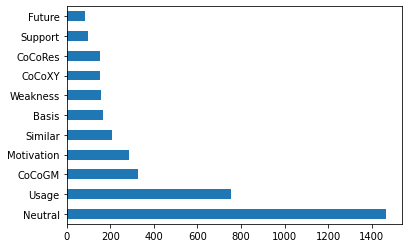

In [ ]:
citation.Cit_func.value_counts().plot(kind='barh')

In [ ]:
display(citation.Cit_func.value_counts())             
print(" ")

Neutral       1463
Usage          755
CoCoGM         328
Motivation     288
Similar        207
Basis          167
Weakness       158
CoCoXY         152
CoCoRes        151
Support        100
Future          85
Name: Cit_func, dtype: int64

**Dropping some rows of Neutral and Usage functions**

In [ ]:
citation.drop(citation.query('Cit_func == "Neutral" ').sample(n=400).index,inplace=True)
citation.drop(citation.query('Cit_func == "Usage" ').sample(n=100).index,inplace=True)

**Converting 11 labels to 6 labels**

In [ ]:
citation['Cit_func'].replace({'Support':'Comparison or Contrast','Neutral':'Background','CoCoXY':'Background','Weakness':'Comparison or Contrast',
                                    'CoCoGM':'Comparison or Contrast','Usage':'Uses','Basis':'Extends','CoCoRes':'Comparison or Contrast',
                                    'Similar':'Comparison or Contrast'}, inplace=True)

In [ ]:
unique_labels = citation.Cit_func.unique()
unique_labels

array(['Future', 'Comparison or Contrast', 'Extends', 'Background',
       'Motivation', 'Uses'], dtype=object)

**One- hot encoding for labels**

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(unique_labels)

citation['label'] = le.transform(citation.Cit_func)

In [ ]:
#Shuffling the dataframe
citation = citation.sample(frac=1).reset_index(drop=True)

**Splitting the dataset**

In [ ]:
#split the subset by rating to create new train, val and test splits
import collections
by_rating = collections.defaultdict(list)
for _,row in citation.iterrows():
  by_rating[row.Cit_func].append(row.to_dict())

In [ ]:
#create split data
seed =1021
final_list = []
np.random.seed(seed)
train_proportion = 0.7
val_proportion = 0.2
test_proportion = 0.1


for _, item_list in sorted(by_rating.items()):
  np.random.shuffle(item_list)

  n_total = len(item_list)
  n_train = int(train_proportion * n_total)
  n_val = int(val_proportion * n_total)
  n_test = int(test_proportion * n_total)


  #give data points  split attribute

  for item in item_list[:n_train]:
    item['split'] = 'train'

  for item in item_list[n_train:n_train+n_val]:
    item['split'] = 'val'

  for item in item_list[n_train+n_val:n_train+n_val+n_test]:
   item['split'] = 'test'


  #Add to final list

  final_list.extend(item_list)


citation = pd.DataFrame(final_list)

In [ ]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split
0,"[Studies, in, communication, and, social, psychology, have, shown, that, evidence, improves, the, persuasiveness, of, a, message, (, CITSEG, ), ., Research, on, the, quantity, of, evidence, indicates, that, there, is, no, optimal, amount, of, evidence, ,, but, that, the, use, of, high, -, quality, evidence, is, consistent, with, persuasive, effects, (, CITSEG, ), ., On, the, other, hand, ,, Cn...",Background,51,"Studies in communication and social psychology have shown that evidence improves the persuasiveness of a message ( CITSEG ) . Research on the quantity of evidence indicates that there is no optimal amount of evidence , but that the use of high - quality evidence is consistent with persuasive effects ( CITSEG ) . On the other hand , Cn'ice 's maxim of quantity ( CITSEG ) specifies that one shou...",0,train
1,"[We, consider, this, number, surprisingly, small, ., It, shows, the, descriptive, power, of, low-level, morphology, -, based, constraints, ., The, most, successful, achievements, so, far, in, the, domain, of, large, -, scale, morphological, disambiguation, of, running, text, have, been, those, for, English, reported, by, CITSEG, ,, on, tagging, the, LOB, corpus, ,, and, CITSEG, ,, on, assignin...",Background,53,"We consider this number surprisingly small . It shows the descriptive power of low-level morphology - based constraints . The most successful achievements so far in the domain of large - scale morphological disambiguation of running text have been those for English reported by CITSEG , on tagging the LOB corpus , and CITSEG , on assigning part -of - speech labels and parsing noun phrases . Suc...",0,train
2,"[See, footnote, 10, ., Thus, ,, "", generalized, coordination, "", ,, instead, of, being, a, family, of, separate, rules, ,, can, be, expressed, as, a, single, rule, on, recursive, descent, through, logical, forms, ., (, CITSEG, ), also, discusses, "", generalized, composition, "", ,, and, it, may, well, be, that, a, similar, implementation, is, possible, for, that, family, of, rules, as, well, .]",Background,35,"See footnote 10 . Thus , "" generalized coordination "" , instead of being a family of separate rules , can be expressed as a single rule on recursive descent through logical forms . ( CITSEG ) also discusses "" generalized composition "" , and it may well be that a similar implementation is possible for that family of rules as well .",0,train
3,"[6, We, chose, nouns, as, a, starting, point, since, nouns, tend, to, allow, less, sense, extensions, than, verbs, and, adjectives, (, CITSEG, ), ., Further, ,, the, noun, hyponymy, hierarchy, in, WordNet, ,, which, will, be, used, as, a, pseudo, -, gold, standard, for, comparison, ,, is, widely, recognized, in, this, area, of, research, ., Some, previous, work, on, distributional, similarity,...",Background,73,"6 We chose nouns as a starting point since nouns tend to allow less sense extensions than verbs and adjectives ( CITSEG ) . Further , the noun hyponymy hierarchy in WordNet , which will be used as a pseudo - gold standard for comparison , is widely recognized in this area of research . Some previous work on distributional similarity between nouns has used only a single grammatical relation ( e...",0,train
4,"[Graph-, based, approaches, for, joint, inference, in, sentiment, analysis, have, been, explored, previously, by, many, researchers, ., The, biggest, difference, between, this, work, and, theirs, is, in, what, the, links, represent, linguistically, ., Some, of, these, are, not, related, to, discourse, at, all, (, e.g., ,, lexical, similarities, (, CITSEG, ), ,, morphosyntactic, similarities, (...",Background,55,"Graph- based approaches for joint inference in sentiment analysis have been explored previously by many researchers . The biggest difference between this work and theirs is in what the links represent linguistically . Some of these are not related to discourse at all ( e.g. , lexic

**Some visualizations after splitting the Dataset**

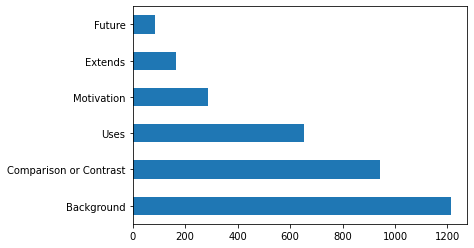

In [ ]:
citation.Cit_func.value_counts().plot(kind='barh')

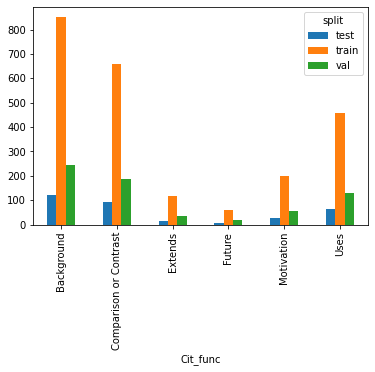

In [ ]:
citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a=citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a.plot(kind='bar')

In [ ]:
citation.groupby(['Cit_func','split']).size()

Cit_func                split
Background              test     121
                        train    850
                        val      243
Comparison or Contrast  test      94
                        train    660
                        val      188
Extends                 test      16
                        train    116
                        val       33
Future                  test       8
                        train     59
                        val       17
Motivation              test      28
                        train    201
                        val       57
Uses                    test      65
                        train    458
                        val      131
dtype: int64

**Tokenizer**

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizerFast.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
special_tokens_dict = {'additional_special_tokens': ['CITSEG']}
tokenizer.add_special_tokens(special_tokens_dict=special_tokens_dict)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Loading BERT tokenizer...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


0

**Splitting the dataset into three datasets: train, val, test**

In [ ]:
df_train = citation[citation.split=='train']
df_val = citation[citation.split=='val']
df_test= citation[citation.split=='test']

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2344, 6)
(669, 6)
(332, 6)


**Shuffling the data splits**

In [ ]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

**Getting texts and labels**

In [ ]:
sentences_train = df_train.text.values
labels_train = df_train.label.values

sentences_valid = df_val.text.values
labels_valid = df_val.label.values

sentences_test = df_test.text.values
labels_test = df_test.label.values

**Creating input ids, attention masks**

In [ ]:
from keras.preprocessing.sequence import pad_sequences
def create_input_ids_attention_maks(sentences, max_len):
  input_ids = []

  # For every sentence...
  for sent in sentences:
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      encoded_sent = tokenizer.encode(
                          sent,                      
                          add_special_tokens = True,
                          max_length = max_len,         
                          truncation=True
                          
                    )
      
      # Add the encoded sentence to the list.
      input_ids.append(encoded_sent)

  
  # pad the sequences
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", 
                            value=0, truncating="post", padding="post")
  

  # Create attention masks
  attention_masks = []

  for sent in input_ids:
      
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]
      
      attention_masks.append(att_mask)

  return [input_ids, attention_masks]

In [ ]:
input_ids_train, attention_masks_train = create_input_ids_attention_maks(sentences_train, 500)
input_ids_valid, attention_masks_valid = create_input_ids_attention_maks(sentences_valid, 500)
input_ids_test, attention_masks_test = create_input_ids_attention_maks(sentences_test, 500)

In [ ]:
input_ids_train.shape

(2344, 500)

**Calculating position of Citseg in tokenised text**

In [ ]:
def calc_tok_cit_seg_id(df,input_id):
  cit_id=df['citseg_id'].values
  k=0
  tok_cid=[]
  for i in input_id:
    cit_seg_tok_id=-1
    #print(i)
    for j in i:
      #print(j)

      cit_seg_tok_id +=1
      if (j==1 and cit_seg_tok_id>= cit_id[k]):
        if(cit_seg_tok_id!= None):
          #print("cit_seg_tok_id for ", k ,"is: ", cit_seg_tok_id)
          tok_cid.append(cit_seg_tok_id)
          #print(k,len(tok_cid))
        else:
          print("no citseg")
        break
    k+=1
  #print(k)
  return tok_cid

In [ ]:
id_train= calc_tok_cit_seg_id(df_train,input_ids_train)
id_val= calc_tok_cit_seg_id(df_val,input_ids_valid) 
id_test= calc_tok_cit_seg_id(df_test,input_ids_test)

In [ ]:
len(id_train)

2344

**Adding Citseg position to Dataframes**

In [ ]:
df_train.loc[:,'tok_citseg_id']=id_train
df_test['tok_citseg_id']=id_test
df_val.loc[:,'tok_citseg_id']=id_val

In [ ]:
df_train.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[In, languages, like, Chinese, ,, where, no, word, boundary, exists, in, written, texts, ,, this, is, by, no, means, an, easy, job, ., In, many, cases, the, machine, will, not, even, realize, that, there, is, an, unfound, word, in, the, sentence, since, most, single, Chinese, characters, can, be, words, by, themselves, ., Purely, statistical, methods, of, word, segmentation, (, e.g., CITSEG, ,...",Comparison or Contrast,60,"In languages like Chinese , where no word boundary exists in written texts , this is by no means an easy job . In many cases the machine will not even realize that there is an unfound word in the sentence since most single Chinese characters can be words by themselves . Purely statistical methods of word segmentation ( e.g. CITSEG , Lua , Huang et al , etc. ) often fail to identify those words...",1,train,65
1,"[So, ,, for, example, ,, we, might, generate, the, PoS, tag, template, Det, NN, Adj, Adv, ,, take, all, the, words, corresponding, to, each, of, these, parts, of, speech, ,, and, combine, bigram, word, sequence, probability, with, the, conditional, probability, of, words, with, respect, to, these, parts, of, speech, ., We, then, use, a, Viterbi-style, algorithm, to, find, the, most, likely, wo...",Comparison or Contrast,80,"So , for example , we might generate the PoS tag template Det NN Adj Adv , take all the words corresponding to each of these parts of speech , and combine bigram word sequence probability with the conditional probability of words with respect to these parts of speech . We then use a Viterbi-style algorithm to find the most likely word sequence . In this model we violate the Markov assumption o...",1,train,86
2,"[The, current, framework, offers, no, support, for, merging, handcrafted, rules, with, new, lexical, rules, obtained, statistically, while, preserving, the, valid, handcrafted, changes, and, deleting, the, invalid, ones, ., In, general, ,, a, better, integration, of, linguistically, based, and, statistical, methods, during, all, the, development, phases, is, greatly, needed, ., The, framework,...",Extends,79,"The current framework offers no support for merging handcrafted rules with new lexical rules obtained statistically while preserving the valid handcrafted changes and deleting the invalid ones . In general , a better integration of linguistically based and statistical methods during all the development phases is greatly needed . The framework represents a generalization of several predecessor ...",2,train,82
3,"[As, our, baseline, parsers, ,, we, use, two, state, -, of, -, theart, lexicalised, parsing, models, ,, namely, the, Bikel, parser, (, CITSEG, ), and, Charniak, parser, (, CITSEG, ), ., While, a, detailed, description, of, the, respective, parsing, models, is, beyond, the, scope, of, this, paper, ,, it, is, worth, noting, that, both, parsers, induce, a, context, free, grammar, as, well, as, a,...",Comparison or Contrast,22,"As our baseline parsers , we use two state - of - theart lexicalised parsing models , namely the Bikel parser ( CITSEG ) and Charniak parser ( CITSEG ) . While a detailed description of the respective parsing models is beyond the scope of this paper , it is worth noting that both parsers induce a context free grammar as well as a generative parsing model from a training set of parse trees , an...",1,train,27
4,"[Since, the, dataset, is, newly, created, for, this, task, ,, to, compare, the, performance, of, the, proposed, method, to, other, models, ,, we, also, reimplemented, several, state, -7, http://code.google.com/p/thebeast, of-, the-, art, methods, for, comparison, ., •, CRF, -, Subj, :, We, follow, the, method, proposed, by, CITSEG, ,, which, regard, the, subjectivity, of, all, clauses, through...",Uses,47,"Since the dataset is newly created for this task , to compare the performance of the proposed method to other models , we also reimplemented several state -7 http://co

In [ ]:
df_val.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[The, subordinate, clause, triggers, the, introduction, of, an, event, marker, ,, e, ,, with, its, event, time, marker, t., The, main, clause, triggers, the, introduction, of, an, event, marker, e, ~, ,, and, its, location, time, marker, t, ~, ,, with, the, DRS, -, condition, e', C, t, ~., The, assymetry, in, using, the, event, time, for, e, and, the, location, time, for, e, ~, arises, from, t...",Background,111,"The subordinate clause triggers the introduction of an event marker , e , with its event time marker t. The main clause triggers the introduction of an event marker e ~ , and its location time marker t ~ , with the DRS - condition e' C t ~. The assymetry in using the event time for e and the location time for e ~ arises from the interpretation rules of temporal connectives ( for both quantifie...",0,val,128
1,"[We, use, the, dataset, from, Athar, (, 2011, ), as, our, starting, point, ,, which, consists, of, 8,736, citations, in, the, ACL, Anthology, (, CITSEG, ), that, cite, a, target, set, of, 310, ACL, Anthology, papers, ., The, citation, summary, data, from, the, ACL, Anthology, Network, 1, (, CITSEG, ), is, used, ., This, dataset, is, rather, large, ,, and, since, manual, annotation, of, context...",Uses,48,"We use the dataset from Athar ( 2011 ) as our starting point , which consists of 8,736 citations in the ACL Anthology ( CITSEG ) that cite a target set of 310 ACL Anthology papers . The citation summary data from the ACL Anthology Network 1 ( CITSEG ) is used . This dataset is rather large , and since manual annotation of context for each citation is a time consuming task , a subset of 20 targ...",5,val,56
2,"[This, strategy, is, certainly, the, right, one, to, start, out, with, ,, since, anaphora, is, always, the, more, typical, direction, of, reference, in, English, prose, (, CITSEG, ,, p., 329, ), ., Since, techniques, developed, elsewhere, may, prove, useful, ,, at, least, for, comparison, ,, it, is, worth, mentioning, at, this, point, that, the, proposed, metarules, are, distant, cousins, of, ...",Comparison or Contrast,111,"This strategy is certainly the right one to start out with , since anaphora is always the more typical direction of reference in English prose ( CITSEG , p. 329 ) . Since techniques developed elsewhere may prove useful , at least for comparison , it is worth mentioning at this point that the proposed metarules are distant cousins of "" unique - name assumption "" ( CITSEG ) , "" domain closure as...",1,val,129
3,"[There, has, been, much, work, in, other, fields, ,, including, linguistics, ,, literary, theory, ,, psychology, ,, philosophy, ,, and, content, analysis, ,, involving, subjective, language, ., As, mentioned, in, Section, 2, ,, the, conceptualization, underlying, our, manual, annotations, is, based, on, work, in, literary, theory, and, linguistics, ,, most, directly, CITSEG, ., We, also, menti...",Future,64,"There has been much work in other fields , including linguistics , literary theory , psychology , philosophy , and content analysis , involving subjective language . As mentioned in Section 2 , the conceptualization underlying our manual annotations is based on work in literary theory and linguistics , most directly CITSEG . We also mentioned existing knowledge resources such as affective lexi...",3,val,67
4,"[OPINE, extracts, explicit, features, for, the, given, product, class, from, parsed, review, data, ., First, ,, the, system, recursively, identifies, both, the, parts, and, the, properties, of, the, given, product, class, and, their, parts, and, properties, ,, in, turn, ,, continuing, until, no, candidates, are, found, ., Then, ,, the, system, finds, related, concepts, as, described, in, (, CI...",Uses,58,"OPINE extracts explicit features for the given product class from parsed review data . First , the system recursively identifies both the parts and the properties of the given product class and their

In [ ]:
df_test.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[While, keystroke, dynamics, is, concerned, with, a, number, of, timing, metrics, ,, such, as, key, holds, (, h, in, Figure, 1, ), and, pauses, between, every, keystroke, (, p, in, Figure, 1, ), ,, the, current, study, looked, only, at, the, pause, preceding, a, word, (, the, second, p, in, Figure, 1, ), ., This, interval, consists, of, the, time, between, the, spacebar, being, released, and, ...",Comparison or Contrast,91,"While keystroke dynamics is concerned with a number of timing metrics , such as key holds ( h in Figure 1 ) and pauses between every keystroke ( p in Figure 1 ) , the current study looked only at the pause preceding a word ( the second p in Figure 1 ) . This interval consists of the time between the spacebar being released and the first key of the word being pressed . We also did not remove an...",1,test,100
1,"[The, relevant, equivalence, is, :, Pron, -, he, -, intra, Rest, (, ~=~)=>~(, Ay, ., Pred, (y, ,, he, ), ), ~, Rest, (~)=~(, Ay, ., Pred, (y, ,, y, ), ), if, binding, _, conditions_hold, ...., This, equivalence, is, doing, essentially, the, same, job, as, Pereira, 's, pronoun, abstraction, schema, in, CITSEG, ., It, will, identify, a, pronoun, with, any, term, of, type, e, elsewhere, in, the, ...",Comparison or Contrast,52,"The relevant equivalence is : Pron - he - intra Rest ( ~=~)=>~( Ay . Pred (y , he ) ) ~ Rest (~)=~( Ay . Pred (y , y ) ) if binding _ conditions_hold .... This equivalence is doing essentially the same job as Pereira 's pronoun abstraction schema in CITSEG . It will identify a pronoun with any term of type e elsewhere in the QLF , relying on the binding conditions to prevent impossible associa...",1,test,75
2,"[Negation, lies, at, the, heart, of, deductive, inference, ,, of, which, consistency, checking, (, searching, for, contradictions, in, texts, ), is, a, prime, example, in, natural, language, understanding, ., It, should, n't, therefore, come, as, a, surprise, that, detecting, negation, and, adequately, representing, its, scope, is, of, utmost, importance, in, computational, semantics, ., In, t...",Uses,76,"Negation lies at the heart of deductive inference , of which consistency checking ( searching for contradictions in texts ) is a prime example in natural language understanding . It should n't therefore come as a surprise that detecting negation and adequately representing its scope is of utmost importance in computational semantics . In this paper we present and evaluate a system that transfo...",5,test,85
3,"[That, is, ,, for, each, m, i, ,, j, ,, we, have, a, corresponding, head, h, a, ,, b, where, i, ≤, a, ≤, b, ≤, j, ., Moreover, ,, for, another, head, h, a, ,, b, ,, we, have, the, satisfying, condition, a, −, b, >, 0, or, b, −, a, <, 0, ∀h, a, ,, b, ,, h, a, ,, b, ., Based, on, this, assumption, ,, the, problem, of, identifying, mention, heads, is, a, sequential, phrase, identification, proble...",Motivation,106,"That is , for each m i , j , we have a corresponding head h a , b where i ≤ a ≤ b ≤ j . Moreover , for another head h a , b , we have the satisfying condition a − b > 0 or b − a < 0 ∀h a , b , h a , b . Based on this assumption , the problem of identifying mention heads is a sequential phrase identification problem , and we choose to employ the BILOU - representation as it has advantages over ...",4,test,112
4,"[CITSEG, adapt, a, statistical, parser, trained, on, the, WSJ, PTB, to, the, biomedical, domain, by, retraining, on, the, Genia, Corpus, ,, augmented, with, manually, corrected, derivations, in, the, same, format, ., To, make, statistical, parsing, more, viable, for, a, range, of, applications, ,, we, need, to, make, more, effective, and, flexible, use, of, extant, training, data, and, minimiz...",Comparison or Contrast,104,"CITSEG adapt a statistical parser trained on the WSJ PTB to the biomedical domain by retraining on the Genia Corpus , augmented with manually corrected derivations 

**Create torch tensors required for DataLoader**

In [ ]:

train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_valid)
citseg_train_inputs=torch.tensor(id_train)
test_inputs = torch.tensor(input_ids_test)


train_labels = torch.tensor(df_train.label.values)
validation_labels = torch.tensor(df_val.label.values)
citseg_validation_inputs=torch.tensor(id_val)
test_labels = torch.tensor(df_test.label.values)

train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_valid)
citseg_test_inputs=torch.tensor(id_test)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

batch_size = 16


# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels,citseg_train_inputs)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,citseg_validation_inputs)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels,citseg_test_inputs)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Custom SciBert Model**

In [ ]:
#Create custom scibert model for sequence classification
class CustomSciBERTModel(nn.Module):
    def __init__(self):
      super(CustomSciBERTModel, self).__init__()
      self.scibert = BertModel.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
      self.num_labels = 6
      self.dropout = nn.Dropout(0.3)
      self.linear_layer = nn.Linear(768, 6)
     

    def forward(self, ids, mask, labels,citseg_id):
      output = self.scibert(
            input_ids=ids, 
            attention_mask=mask)
      last_hidden_states = output[0]
      
      #gather function
      batch_size,columns=ids.shape
      citseg_id = citseg_id.view(batch_size,1,1)
      citseg_id = citseg_id.repeat(1,1,768)
      pooled_states2 = torch.gather(input=last_hidden_states, dim=1, index=citseg_id)
      #print("pooled_states2:", pooled_states2)
      citseg_feature_vector = torch.squeeze(pooled_states2, dim=1)


      #logits = self.dropout(output[1])
      #logits = self.linear_layer(logits[1])
      logits = self.linear_layer(citseg_feature_vector) 

      loss = None
      # while training return loss and while validation/ testing resturn logits
      if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss
      else:
        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Create model object
model = CustomSciBERTModel()

# Get model on to GPU
model.cuda()

# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of epochs
epochs = 20

# training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at /content/drive/MyDrive/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is depre

In [ ]:
# Compute accuracy
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
def macroscore(preds,labels):
  pred = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()
  val_macro_f1_score = f1_score(labels, pred, average='macro')
  return val_macro_f1_score 

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

true, pred = [], []

predictions=[]
prediction=[]
y=[]

# Store the average loss after each epoch so we can plot them.
training_loss_values = []
validation_loss_values= []

# set initial loss to infinite
best_valid_loss = float('inf')

# store predictions on validation data
valid_preds = []

max_val_f1_score=0

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains four pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #   [3]: citseg ids 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_citseg_id=batch[3].to(device)
        

        # backward pass. PyTorch doesn't do this automatically because 
        model.zero_grad()        

        # Forward pass
        outputs = model(ids = b_input_ids, mask = b_input_mask, labels = b_labels, citseg_id=b_citseg_id)
        
        # forward pass gives loss as output
        loss = outputs

        # accumulate loss
        total_loss += loss.item()

        # backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0. to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    training_loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Reset the total validation loss for this epoch.
    total_valid_loss = 0

    # evaluation mode.
    model.eval()

    # evaluation loss and accuracy
    eval_loss, eval_accuracy = 0, 0
    running_loss, running_acc= 0 , 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels,b_citseg_id = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # It gives logits when labels are not given to model
            outputs = model(b_input_ids, 
                            b_input_mask, labels = None, citseg_id=b_citseg_id)
        
        # Get the "logits" output by the model. The "logits" are the output
        logits = outputs

        # Track the number of batches
        nb_eval_steps += 1

        # compute the loss
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, b_labels)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (nb_eval_steps)    

        # Calculate the average loss over the validating data.
        # accumulate loss
        total_valid_loss += loss.item()
        avg_valid_loss = total_valid_loss / len(validation_dataloader)
         
         #save the best model
        if avg_valid_loss < best_valid_loss:
          best_valid_loss = avg_valid_loss
          torch.save(model.state_dict(), 'saved_weights.pt') 

        

        #appending predictions and true labels for last epoch
        if(epoch_i==epochs-1):
          _, predictions = logits.max(dim=1)
          prediction.append(predictions)
          y.append(b_labels)

        #compute the accuracy
        acc_t = compute_accuracy(logits, b_labels)
        running_acc += (acc_t - running_acc) / (nb_eval_steps)


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        valid_preds.extend(np.argmax(logits, axis=1).flatten())
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        #calculate macro f1 score
        val_f1_score=macroscore(logits, label_ids)

        if val_f1_score>max_val_f1_score:
          max_val_f1_score=val_f1_score

        

    # Store the loss value for plotting the learning curve.
    validation_loss_values.append(avg_valid_loss)
    
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Average Validation loss: {0:.2f}".format(avg_valid_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    print("The Val macro f1 score is: ", max_val_f1_score)
    print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_i, running_loss, running_acc))
      
    

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:34.
  Batch    80  of    147.    Elapsed: 0:01:08.
  Batch   120  of    147.    Elapsed: 0:01:43.

  Average training loss: 1.17
  Training epcoh took: 0:02:05

Running Validation...
  Accuracy: 0.62
  Average Validation loss: 1.02
  Validation took: 0:00:13
The Val macro f1 score is:  0.8533333333333333
Epoch 0	 val_loss=1.020500947322164	 val_acc=61.96199633699634

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:34.
  Batch    80  of    147.    Elapsed: 0:01:08.
  Batch   120  of    147.    Elapsed: 0:01:42.

  Average training loss: 0.68
  Training epcoh took: 0:02:05

Running Validation...
  Accuracy: 0.71
  Average Validation loss: 0.82
  Validation took: 0:00:13
The Val macro f1 score is:  0.9
Epoch 1	 val_loss=0.8238686741817567	 val_acc=70.99358974358975

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:34.
  Batch    

In [ ]:
training_loss_values 

[1.1697889550202558,
 0.6764137866545696,
 0.3553911295472359,
 0.16636815205292435,
 0.08782549619874251,
 0.05579378958482637,
 0.043368386882092,
 0.037556404793923276,
 0.027655130931578946,
 0.020509810835571695,
 0.01555314965306173,
 0.016416632419313085,
 0.01541411343697248,
 0.012331827969368917,
 0.01138578706567863,
 0.00992379554392545,
 0.009268454851122924,
 0.00864451389812146,
 0.006511959643410059,
 0.006586982287698367]

In [ ]:
validation_loss_values

[1.0205009473221642,
 0.8238686741817565,
 0.8829068190285138,
 1.1208892076143198,
 1.3319192929636865,
 1.6100841077665489,
 1.5452119834898483,
 1.877441757003821,
 1.9335908091494016,
 1.843827131337353,
 1.8928657121778953,
 1.8984522324587618,
 1.8375695567311985,
 1.8660165975563272,
 1.8880527729966812,
 1.8798851628311066,
 1.9237206446760822,
 1.9077847256585734,
 1.929964136177053,
 1.923645026493995]

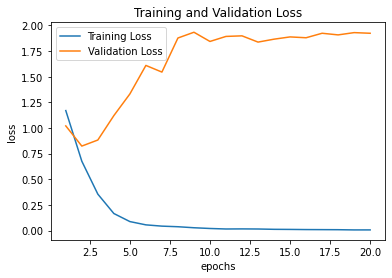

In [ ]:
import matplotlib.pyplot as plt
# line 1 points
x1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
y1 = training_loss_values
# plotting the line 1 points 
plt.plot(x1, y1, label = "Training Loss")
# line 2 points

y2 = validation_loss_values
# plotting the line 2 points 
plt.plot(x1, y2, label = "Validation Loss")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# Set a title of the current axes.
plt.title('Training and Validation Loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
y.pop()

tensor([0, 5, 5, 5, 5, 2, 0, 4, 1, 5, 0, 5, 5], device='cuda:0')

In [ ]:
prediction.pop()

tensor([5, 5, 5, 5, 2, 1, 1, 4, 1, 5, 5, 1, 5], device='cuda:0')

In [ ]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [ ]:
true_y=y_tensor.cpu().detach().numpy()
pred_y=pred_tensor.cpu().detach().numpy()

In [ ]:
true_y.shape

(41, 16)

In [ ]:
pred_y=pred_y.flatten()

In [ ]:
true_y=true_y.flatten()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.81      0.70      0.75       240
Comparison or Contrast       0.76      0.85      0.80       187
               Extends       0.67      0.56      0.61        32
                Future       0.70      0.82      0.76        17
            Motivation       0.59      0.70      0.64        56
                  Uses       0.73      0.75      0.74       124

              accuracy                           0.75       656
             macro avg       0.71      0.73      0.72       656
          weighted avg       0.75      0.75      0.75       656



In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [ ]:
cf_matrix

array([[168,  31,   3,   3,  16,  19],
       [ 13, 159,   2,   2,   6,   5],
       [  4,   2,  18,   0,   0,   8],
       [  1,   2,   0,  14,   0,   0],
       [  7,   8,   0,   0,  39,   2],
       [ 14,   7,   4,   1,   5,  93]])

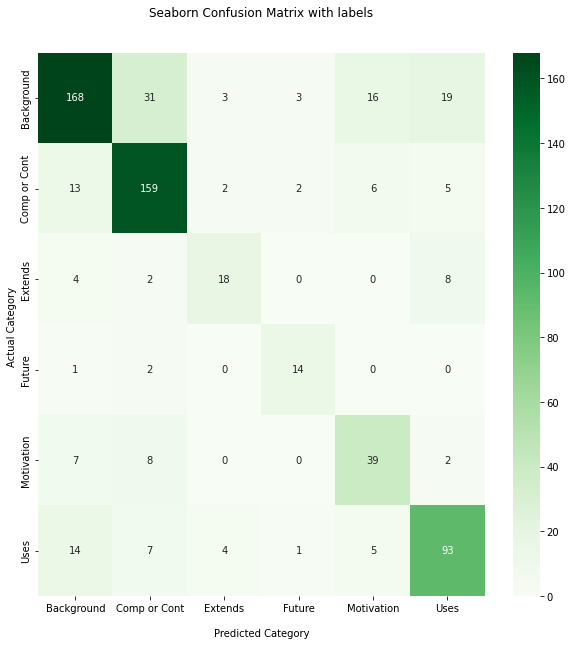

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()


**Testing**

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
tot_pred=[]
tot_labels=[]
input_ids=[]

for batch in test_dataloader:
        
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_citseg_id = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # It gives logits when labels are not given to model
        outputs = model(b_input_ids, 
                        b_input_mask, labels = None, citseg_id=b_citseg_id)
    
    # Get the "logits" output by the model. The "logits" are the output
    #logits = outputs
    _, logits = outputs.max(dim=1)
    tot_pred.append(logits)
    tot_labels.append(b_labels)
    input_ids.append(b_input_ids)

In [ ]:
tot_labels.pop()

tensor([1, 1, 0, 1, 0, 0, 5, 1, 4, 0, 5, 5], device='cuda:0')

In [ ]:
tot_pred.pop()

tensor([0, 1, 0, 0, 0, 0, 5, 1, 4, 0, 5, 0], device='cuda:0')

In [ ]:
input_ids.pop()

tensor([[ 102,  106, 4073,  ...,    0,    0,    0],
        [ 102,  168,  111,  ...,    0,    0,    0],
        [ 102,  168,  535,  ...,    0,    0,    0],
        ...,
        [ 102,  111, 2365,  ...,    0,    0,    0],
        [ 102,  168,  238,  ...,    0,    0,    0],
        [ 102,  130, 1143,  ...,    0,    0,    0]], device='cuda:0')

In [ ]:
tot_labels_tensor = torch.stack(tot_labels)
tot_pred_tensor = torch.stack(tot_pred)
input_ids_tensor=torch.stack(input_ids)

In [ ]:
true_y=tot_labels_tensor.cpu().detach().numpy()
pred_y=tot_pred_tensor.cpu().detach().numpy()
input_id=input_ids_tensor.cpu().detach().numpy()

In [ ]:
sent=[]
for i in (input_ids_tensor):
  for j in i:
    x=tokenizer.convert_ids_to_tokens(j)
    #print(x)
    sent.append(x)

In [ ]:
pred_y=pred_y.flatten()

In [ ]:
true_y=true_y.flatten()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.74      0.88      0.80       117
Comparison or Contrast       0.81      0.60      0.69        90
               Extends       0.62      0.31      0.42        16
                Future       0.83      0.62      0.71         8
            Motivation       0.56      0.70      0.62        27
                  Uses       0.77      0.82      0.80        62

              accuracy                           0.74       320
             macro avg       0.72      0.66      0.67       320
          weighted avg       0.75      0.74      0.73       320



In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [ ]:
cf_matrix

array([[103,   4,   0,   0,   5,   5],
       [ 26,  54,   0,   1,   6,   3],
       [  2,   2,   5,   0,   1,   6],
       [  0,   3,   0,   5,   0,   0],
       [  4,   3,   0,   0,  19,   1],
       [  4,   1,   3,   0,   3,  51]])

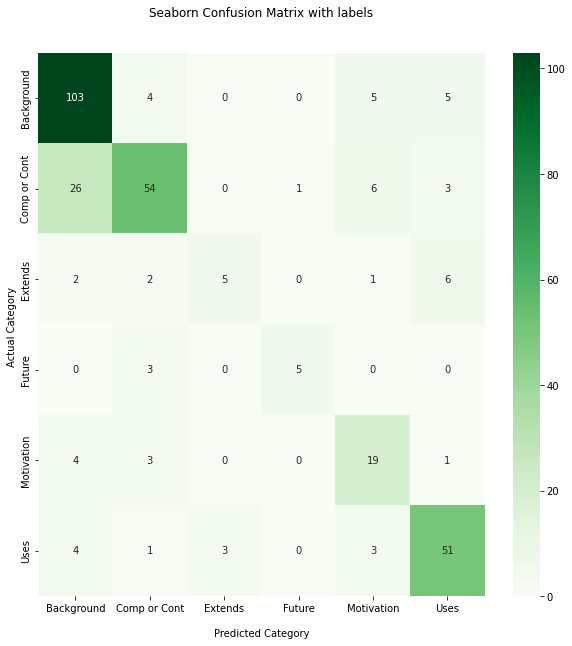

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()
plt.savefig("cf_testing1.png")

In [ ]:
df=pd.DataFrame()
df['Actual Label']= true_y
df['Tokenised Text']=sent
df['predictions']= pred_y

In [ ]:
df['predictions']=df['predictions'].replace({0:"Background",1:"Comp or Cont", 2:"Extends", 3:"Future", 4:"Motivation", 5:"Uses"})
df['Actual Label']= df['Actual Label'].replace({0:"Background",1:"Comp or Cont", 2:"Extends", 3:"Future", 4:"Motivation", 5:"Uses"})

In [ ]:
df

,Actual Label,Tokenised Text,predictions
0,Comp or Cont,"[[CLS], while, keys, ##tro, ##ke, dynamics, is, concerned, with, a, number, of, timing, metrics, ,, such, as, key, holds, (, h, in, figure, 1, ), and, pause, ##s, between, every, keys, ##tro, ##ke, (, p, in, figure, 1, ), ,, the, current, study, looked, only, at, the, pause, preceding, a, word, (, the, second, p, in, figure, 1, ), ., this, interval, consists, of, the, time, between, the, space...",Comp or Cont
1,Comp or Cont,"[[CLS], the, relevant, equivalence, is, :, pron, -, he, -, intra, rest, (, ~, =, ~, ), =, >, ~, (, ay, ., pred, (, y, ,, he, ), ), ~, rest, (, ~, ), =, ~, (, ay, ., pred, (, y, ,, y, ), ), if, binding, _, conditions, _, hold, ., ., ., ., this, equivalence, is, doing, essentially, the, same, job, as, per, ##ei, ##ra, ', s, pronoun, abstraction, schema, in, CITSEG, ., it, will, identify, a, pron...",Background
2,Uses,"[[CLS], negation, lies, at, the, heart, of, deduc, ##tive, inference, ,, of, which, consistency, checking, (, searching, for, contradiction, ##s, in, texts, ), is, a, prime, example, in, natural, language, understanding, ., it, should, n, ', t, therefore, come, as, a, surprise, that, detecting, negation, and, adequately, representing, its, scope, is, of, ut, ##most, importance, in, computation...",Uses
3,Motivation,"[[CLS], that, is, ,, for, each, m, i, ,, j, ,, we, have, a, corresponding, head, h, a, ,, b, where, i, ≤, a, ≤, b, ≤, j, ., moreover, ,, for, another, head, h, a, ,, b, ,, we, have, the, satisfying, condition, a, −, b, >, 0, or, b, −, a, <, 0, ∀, ##h, a, ,, b, ,, h, a, ,, b, ., based, on, this, assumption, ,, the, problem, of, identifying, mention, heads, is, a, sequential, phrase, identificat...",Motivation
4,Comp or Cont,"[[CLS], CITSEG, adapt, a, statistical, parser, trained, on, the, ws, ##j, pt, ##b, to, the, biomedical, domain, by, retr, ##aining, on, the, gen, ##ia, corpus, ,, augmented, with, manually, corrected, derivations, in, the, same, format, ., to, make, statistical, parsing, more, viable, for, a, range, of, applications, ,, we, need, to, make, more, effective, and, flexible, use, of, extant, train...",Background
5,Motivation,"[[CLS], motivated, by, the, argument, structure, of, discourse, relations, used, in, penn, discourse, tree, ##bank, (, CITSEG, ), ,, in, this, work, ,, we, adopt, the, clause, unit, -, based, definition, ., it, means, that, clauses, are, treated, as, the, basic, units, of, opinion, expressions, and, explanations, ., let, d, =, {, c, 1, ,, c, 2, ,, ., ., ., c, n, }, be, the, clauses, of, docume...",Motivation
6,Uses,"[[CLS], to, extract, such, patterns, ,, we, first, used, the, gen, ##ia, tag, ##ger, (, CITSEG, ), ,, a, part, -, of, -, speech, tag, ##ger, trained, on, a, biomedical, corpus, ,, to, tag, every, word, in, the, sentence, ., then, ,, we, used, the, rules, to, extract, all, phrases, and, termin, ##ologies, that, correspond, to, the, above, mentioned, patterns, ., the, results, are, presented, in...",Uses
7,Comp or Cont,"[[CLS], as, the, improvement, of, the, f, 1, score, due, to, the, additional, features, is, not, statistically, significant, ,, we, use, the, set, of, eighteen, baseline, features, for, simplicity, ., these, features, are, reproduced, in, table, 1, for, easy, reference, ., unlike, in, (, CITSEG, ), ,, we, do, not, pr, ##une, arguments, dominated, by, other, arguments, or, those, that, overlap,...",Comp or Cont
8,Comp or Cont,"[[CLS], using, part, of, the, gig, ##a, -, fre, ##n, data, -, along, with, the, additions, to, the, europ, ##ar, ##l, ,, news, commentary, ,, and, un, document, courses, released, since, last, year, -, is, beneficial, to, translation, quality, ,, as, there, is, a, clear, improvement, in, metric, scores, between, the, 2010, and, 2011, systems, ., our, ble, ##u, score, improvements, of, 1, ., 2,...",Comp or Cont
9,Background,"[[CLS], several, approaches, have, been, suggested, to, account, for, this, behavior, ., [, CITSEG, ], introduced, an, 